In [1]:
from gdc.cms.data_access import *
import seaborn as sns

In [2]:
ZF = get_zip_files()

In [3]:
get_zipfile_metrics(ZF.DE1_0_2008_Beneficiary_Summary_File_Sample_1)

namespace(columns=['DESYNPUF_ID',
                   'BENE_BIRTH_DT',
                   'BENE_DEATH_DT',
                   'BENE_SEX_IDENT_CD',
                   'BENE_RACE_CD',
                   'BENE_ESRD_IND',
                   'SP_STATE_CODE',
                   'BENE_COUNTY_CD',
                   'BENE_HI_CVRAGE_TOT_MONS',
                   'BENE_SMI_CVRAGE_TOT_MONS',
                   'BENE_HMO_CVRAGE_TOT_MONS',
                   'PLAN_CVRG_MOS_NUM',
                   'SP_ALZHDMTA',
                   'SP_CHF',
                   'SP_CHRNKIDN',
                   'SP_CNCR',
                   'SP_COPD',
                   'SP_DEPRESSN',
                   'SP_DIABETES',
                   'SP_ISCHMCHT',
                   'SP_OSTEOPRS',
                   'SP_RA_OA',
                   'SP_STRKETIA',
                   'MEDREIMB_IP',
                   'BENRES_IP',
                   'PPPYMT_IP',
                   'MEDREIMB_OP',
                   'BENRES_OP',
        

In [4]:
chunks = zip_chunk_generator(ZF.DE1_0_2008_Beneficiary_Summary_File_Sample_1, 10, 1)

In [5]:
next(chunks)

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,00013D2EFD8E45D1,19230501,NaN,1,1,0,26,950,12,12,...,2,0.0,0.0,0.0,50.0,10.0,0.0,0.0,0.0,0.0
1,00016F745862898F,19430101,NaN,1,1,0,39,230,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,700.0,240.0,0.0
2,0001FDD721E223DC,19360901,NaN,2,1,0,39,280,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00021CA6FF03E670,19410601,NaN,1,5,0,6,290,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00024B3D2352D2D0,19360801,NaN,1,1,0,52,590,12,12,...,2,0.0,0.0,0.0,30.0,40.0,0.0,220.0,80.0,0.0
5,0002DAE1C81CC70D,19431001,NaN,1,2,0,33,400,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0002F28CE057345B,19220701,NaN,1,1,0,39,270,12,12,...,2,0.0,0.0,0.0,1010.0,270.0,0.0,3330.0,940.0,0.0
7,000308435E3E5B76,19350901,NaN,1,1,0,24,680,10,10,...,2,0.0,0.0,0.0,150.0,160.0,0.0,870.0,340.0,80.0
8,000345A39D4157C9,19760901,NaN,2,1,0,23,810,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00036A21B65B0206,19381001,NaN,2,2,0,1,570,12,12,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
CB = load_codebook()

In [7]:
CB.__dict__

{'patient_id': 'DESYNPUF_ID',
 'date_birth': 'BENE_BIRTH_DT',
 'date_death': 'BENE_DEATH_DT',
 'sex': 'BENE_SEX_IDENT_CD',
 'race': 'BENE_RACE_CD',
 'cc_esrd_indicator': 'BENE_ESRD_IND',
 'state_code': 'SP_STATE_CODE',
 'county_code': 'BENE_COUNTY_CD',
 'months_partA': 'BENE_HI_CVRAGE_TOT_MONS',
 'months_partB': 'BENE_SMI_CVRAGE_TOT_MONS',
 'months_hmo': 'BENE_HMO_CVRAGE_TOT_MONS',
 'months_partD': 'PLAN_CVRG_MOS_NUM',
 'cc_alzheimer': 'SP_ALZHDMTA',
 'cc_chf': 'SP_CHF',
 'cc_chronic_kidney': 'SP_CHRNKIDN',
 'cc_cancer': 'SP_CNCR',
 'cc_copd': 'SP_COPD',
 'cc_depression': 'SP_DEPRESSN',
 'cc_diabetes': 'SP_DIABETES',
 'cc_ischemic_heart': 'SP_ISCHMCHT',
 'cc_osteoporosis': 'SP_OSTEOPRS',
 'cc_ra_oa': 'SP_RA_OA',
 'cc_stroke_tia': 'SP_STRKETIA',
 'medicare_reimb_ip': 'MEDREIMB_IP',
 'beneficiary_resp_ip': 'BENRES_IP',
 'primary_payer_ip': 'PPPYMT_IP',
 'medicare_reimb_op': 'MEDREIMB_OP',
 'beneficiary_resp_op': 'BENRES_OP',
 'primary_payer_op': 'PPPYMT_OP',
 'medicare_reimb_car': 'MEDRE

In [8]:
df_beneficiaries_2008[[CB.date_birth, 'age']]

,BENE_BIRTH_DT,age
0,19230501,84.666667
1,19430101,65.000000
2,19360901,71.333333
3,19410601,66.583333
4,19360801,71.416667
...,...,...
116347,19430701,64.500000
116348,19160601,91.583333
116349,19390401,68.750000
116350,19110701,96.500000


In [9]:
binary_characteristics

['cc_esrd_indicator',
 'cc_alzheimer',
 'cc_chf',
 'cc_chronic_kidney',
 'cc_cancer',
 'cc_copd',
 'cc_depression',
 'cc_diabetes',
 'cc_ischemic_heart',
 'cc_osteoporosis',
 'cc_ra_oa',
 'cc_stroke_tia']

In [10]:
df_beneficiaries_2008[[CB[c] for c in binary_characteristics]].describe()

,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA
count,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000,116352.000000
mean,1.807395,1.715046,1.839401,1.936271,1.864695,1.786510,1.621322,1.579363,1.826587,1.846019,1.955110
std,0.394347,0.451395,0.367162,0.244271,0.342050,0.409773,0.485060,0.493664,0.378606,0.360932,0.207063
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [11]:
df_beneficiaries_2008[CB.cc_esrd_indicator].value_counts()

BENE_ESRD_IND
0    108091
Y      8261
Name: count, dtype: int64

In [12]:
medicare_payment

['MEDREIMB_CAR', 'MEDREIMB_IP', 'MEDREIMB_OP']

In [13]:
df_beneficiaries_2008[CB.state_code].value_counts()

SP_STATE_CODE
5     10224
10     7745
45     6703
33     6510
39     5199
36     4329
14     4277
23     4012
34     3935
31     3176
11     3012
49     2895
44     2803
22     2587
1      2570
15     2497
26     2378
52     2371
3      2325
50     2282
6      2012
24     1982
18     1864
4      1851
42     1848
21     1837
38     1725
19     1715
37     1663
54     1628
7      1473
25     1331
16     1317
51     1152
17     1142
32     1119
46      889
29      842
28      713
20      692
13      675
41      674
30      644
12      544
53      501
8       493
27      429
35      420
43      419
47      374
9       310
2       244
Name: count, dtype: int64

In [14]:
df_beneficiaries_2008[CB.race].value_counts()

BENE_RACE_CD
1    96349
2    12343
3     4931
5     2729
Name: count, dtype: int64

In [15]:
df_2008_w_dummies

NameError: name 'df_2008_w_dummies' is not defined

In [27]:
df_2008_w_dummies['payments'] = df_2008_w_dummies[medicare_payment].sum(axis=1)

In [28]:
df_2008_w_dummies['payments'].describe()

count    116352.000000
mean       3998.503163
std        9847.702381
min        -430.000000
25%           0.000000
50%         940.000000
75%        3040.000000
max      170190.000000
Name: payments, dtype: float64

In [29]:
df_2008_w_dummies.head()

,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_RACE_CD,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,MEDREIMB_IP,...,SP_CNCR_2,SP_COPD_2,SP_DEPRESSN_2,SP_DIABETES_2,SP_ISCHMCHT_2,SP_OSTEOPRS_2,SP_RA_OA_2,SP_STRKETIA_2,BENE_SEX_IDENT_CD_2,payments
DESYNPUF_ID,,,,,,,,,,,,,,,,,,,,,
00013D2EFD8E45D1,19230501,NaN,1,26,950,12,12,12,12,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,50.0
00016F745862898F,19430101,NaN,1,39,230,12,12,0,0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,700.0
0001FDD721E223DC,19360901,NaN,1,39,280,12,12,0,12,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
00021CA6FF03E670,19410601,NaN,5,6,290,0,0,0,0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
00024B3D2352D2D0,19360801,NaN,1,52,590,12,12,0,0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,250.0


In [30]:
Y = df_2008_w_dummies['payments']

In [31]:
cols_to_drop = ['payments', 'Year', CB.beneficiary_resp_car, CB.beneficiary_resp_ip, CB.beneficiary_resp_op,
                CB.medicare_reimb_car, CB.medicare_reimb_ip, CB.medicare_reimb_op, CB.county_code,
                CB.date_birth, CB.date_death, CB.race, CB.state_code, CB.primary_payer_car, CB.primary_payer_ip, CB.primary_payer_op,
               CB.months_hmo, CB.months_partA, CB.months_partB]
X = df_2008_w_dummies.drop(columns=cols_to_drop)

In [32]:
X

,PLAN_CVRG_MOS_NUM,age,BENE_ESRD_IND_Y,SP_ALZHDMTA_2,SP_CHF_2,SP_CHRNKIDN_2,SP_CNCR_2,SP_COPD_2,SP_DEPRESSN_2,SP_DIABETES_2,SP_ISCHMCHT_2,SP_OSTEOPRS_2,SP_RA_OA_2,SP_STRKETIA_2,BENE_SEX_IDENT_CD_2
DESYNPUF_ID,,,,,,,,,,,,,,,
00013D2EFD8E45D1,12,84.666667,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
00016F745862898F,0,65.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
0001FDD721E223DC,12,71.333333,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00021CA6FF03E670,0,66.583333,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
00024B3D2352D2D0,0,71.416667,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FFFD7C464C94D136,12,64.500000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
FFFE3ED9582AD46E,12,91.583333,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
FFFE7AB5D7F1725D,12,68.750000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
CB.cc_cancer

'SP_CNCR'

In [34]:
import statsmodels.api as sm

X_ = sm.add_constant(X)   # adds intercept
res = sm.OLS(Y, X_).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               payments   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     4668.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        06:17:21   Log-Likelihood:            -1.2075e+06
No. Observations:              116352   AIC:                         2.415e+06
Df Residuals:                  116336   BIC:                         2.415e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.805e+04    207.273    135.344      0.000    2.76e+04    2.85e+04
PLAN_CVRG_MOS_NUM     -17.9527      3.983     -4.507      0.000     -25.760     -10.146
age                     2.4365      1.844      1.321      0.186      -1.177       6.050
BENE_ESRD_IND_Y      4325.8005     99.927     43.290      0.000    4129.945    4521.656
SP_ALZHDMTA_2       -1584.1436     65.449    -24.204      0.000   -1712.424   -1455.864
SP_CHF_2            -1970.0568     63.047    -31.248      0.000   -2093.628   -1846.486
SP_CHRNKIDN_2       -5684.0343     78.898    -72.043      0.000   -5838.674   -5529.395
SP_CNCR_2           -4110.0564     96.720    -42.494      0.000   -4299.627   -3920.486
SP_COPD_2           -4960.9961     76.516    -64.836      0.000   -5110.967   -4811.025
SP_DEPRESSN_2        -999.0816     62.637    -15.950      0.000   -1121.848    -876.315
SP_DIABETES_2        -253.9125     60.259     -4.214      0.000    -372.020    -135.805
SP_ISCHMCHT_2        -988.4737     58.906    -16.781      0.000   -1103.928    -873.019
SP_OSTEOPRS_2        -266.4278     64.255     -4.146      0.000    -392.366    -140.489
SP_RA_OA_2          -1181.1602     69.170    -17.076      0.000   -1316.731   -1045.589
SP_STRKETIA_2       -6273.7535    116.178    -54.001      0.000   -6501.461   -6046.046
BENE_SEX_IDENT_CD_2  -158.9542     46.409     -3.425      0.001    -249.915     -67.993
==============================================================================
Omnibus:                   120832.865   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11451677.338
Skew:                           5.104   Prob(JB):                         0.00
Kurtosis:                      50.518   Cond. No.                         699.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
res.resid.describe()

count    1.163520e+05
mean    -1.551844e-10
std      7.780762e+03
min     -2.703012e+04
25%     -1.746338e+03
50%      1.901970e+02
75%      5.019181e+02
max      1.500419e+05
dtype: float64

In [36]:
res = sm.QuantReg(Y, X_).fit(q=0.9)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               payments   Pseudo R-squared:               0.4900
Model:                       QuantReg   Bandwidth:                       408.9
Method:                 Least Squares   Sparsity:                        9933.
Date:                Tue, 13 Jan 2026   No. Observations:               116352
Time:                        06:17:27   Df Residuals:                   116336
                                        Df Model:                           15
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.771e+04     80.181    719.762      0.000    5.76e+04    5.79e+04
PLAN_CVRG_MOS_NUM     -18.7459      1.528    -12.272      0.000     -21.740     -15.752
age                     3.9361      0.724      5.440      0.000       2.518       5.354
BENE_ESRD_IND_Y      1.003e+04     35.285    284.359      0.000    9964.349    1.01e+04
SP_ALZHDMTA_2       -2187.1313     23.605    -92.654      0.000   -2233.397   -2140.865
SP_CHF_2            -2532.2257     21.253   -119.146      0.000   -2573.881   -2490.570
SP_CHRNKIDN_2       -1.462e+04     26.391   -553.989      0.000   -1.47e+04   -1.46e+04
SP_CNCR_2           -7291.1434     36.311   -200.796      0.000   -7362.313   -7219.974
SP_COPD_2           -1.021e+04     27.073   -377.228      0.000   -1.03e+04   -1.02e+04
SP_DEPRESSN_2       -1634.6231     23.134    -70.659      0.000   -1679.966   -1589.281
SP_DIABETES_2       -1240.3446     22.605    -54.870      0.000   -1284.650   -1196.039
SP_ISCHMCHT_2       -1887.0666     21.252    -88.794      0.000   -1928.720   -1845.413
SP_OSTEOPRS_2        -952.7094     24.600    -38.727      0.000   -1000.926    -904.493
SP_RA_OA_2          -2356.8089     26.065    -90.419      0.000   -2407.897   -2305.721
SP_STRKETIA_2       -1.239e+04     43.265   -286.296      0.000   -1.25e+04   -1.23e+04
BENE_SEX_IDENT_CD_2    -4.1642     17.847     -0.233      0.816     -39.144      30.816
=======================================================================================
"""

In [37]:
res.resid.describe()

count    116352.000000
mean      -5307.626518
std       10326.760110
min      -62594.380463
25%       -7249.301307
50%       -1356.156294
75%        -472.998086
max      136743.490089
dtype: float64

In [38]:
import numpy as np

def top_quantile_payment_share(s, q):
    cutoff = s.quantile(q)
    return s[s >= cutoff].sum() / s.sum()

In [39]:
qs = np.linspace(0.5, 1.0, 50)
shares = np.array([top_quantile_payment_share(Y, q) for q in qs])


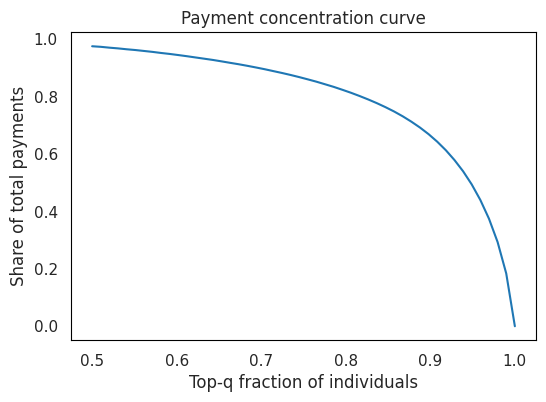

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(qs, shares)
plt.xlabel("Top-q fraction of individuals")
plt.ylabel("Share of total payments")
plt.title("Payment concentration curve")
plt.grid(True)
plt.show()
